# Linear Classifier (Logistic Regression)

# Introduction

This tutorial covers the implementation of a simple linear model using TensorFlow. We will implement this model for classifying images of hand-written digits from the so-called MNIST data-set. The structure of the network is presented in the following figure.


<img src="files/files/linear_classifier.png">


___Fig. 1-___ Sample Logistic Regression structure implemented for classifying MNIST digits 

You should be familiar with basic linear algebra, Machine Learning and classification. To specifically learn about the linear classifiers, read [this](https://cs231n.github.io/linear-classify/) article.

Technically, in a linear model we will use the simplest function to predict the label $\mathbf{y_i}$ of the image $\mathbf{x_i}$. We'll do so by using a linear mapping like $f(\mathbf{x_i}, \mathbf{W}, \mathbf{b})=\mathbf{W}\mathbf{x_i}+\mathbf{b}$ where $\mathbf{W}$ and $\mathbf{b}$ are called weight matrix and bias vector respectively. 
 


## 0. Import the required libraries:
We will start with importing the required Python libraries. 

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Load the MNIST data

For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning and is easily accesible through Tensorflow

The dataset contains 55,000 examples for training, 5,000 examples for validation and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

<img src="files/files/mnist.png">


If you want to know more about the MNIST dataset you can check __Yann Lecun__'s [website](http://yann.lecun.com/exdb/mnist/).

### 1.1. Data dimension
Here, we specify the dimensions of the images which will be used in several places in the code below. Defining these variables makes it easier (compared with using hard-coded number all throughout the code) to modify them later. Ideally these would be inferred from the data that has been read, but here we will just write the numbers.

It's important to note that in a linear model, we have to flatten the input images into a vector. Here, each of the $28\times28$ images are flattened into a $1\times784$ vector. 

In [2]:
img_h = img_w = 28             # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10                 # Number of classes, one class per digit

### 1.2. Helper functions to load the MNIST data

In this section, we'll write the function which automatically loads the MNIST data and returns it in our desired shape and format. If you wanna learn more about loading your data, you may read our __How to Load Your Data in TensorFlow __ tutorial which explains all the available methods to load your own data; no matter how big it is. 

Here, we'll simply write a function (load_data) which has two modes: train (which loads the training and validation images and their corresponding labels) and test (which loads the test images and their corresponding labels). 

Other than a function for loading the images and corresponding labels, we define two more functions:

1. __randomize__: which randomizes the order of images and their labels. This is important to make sure that the input images are sorted in a completely random order. Moreover, at the beginning of each __epoch__, we will re-randomize the order of data samples to make sure that the trained model is not sensitive to the order of data.

2. __get_next_batch__: which only selects a few number of images determined by the batch_size variable (if you don't know why, read about Stochastic Gradient Method)


In [3]:
def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test


def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y


def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### 1.3. Load the data and display the sizes
Now we can use the defined helper function in __train__ mode which loads the train and validation images and their corresponding labels. We'll also display their sizes:

In [5]:
# Load MNIST data
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Validation-set:	5000


To get a better sense of the data, let's checkout the shapes of the loaded arrays.

In [6]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_train:\t{}'.format(x_valid.shape))
print('y_valid:\t{}'.format(y_valid.shape))

x_train:	(55000, 784)
y_train:	(55000, 10)
x_train:	(5000, 784)
y_valid:	(5000, 10)


As you can see, x_train and x_valid arrays contain 55000 and 5000 flattened images ( of size 28x28=784 values). y_train and y_valid contain the corresponding labels of the images in the training and validation set respectively. 

Based on the dimesnion of the arrays, for each image, we have 10 values as its label. Why? This technique is called __One-Hot Encoding__. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i^{th}$ element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the validation set are:

In [7]:
y_valid[:5, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

where the 10 values in each row represents the label assigned to that partiular image. 

## 2. Hyperparameters

Here, we have about 55,000 images in our training set. It takes a long time to calculate the gradient of the model using all these images. We therefore use __Stochastic Gradient Descent__ which only uses a small batch of images in each iteration of the optimizer. Let's define some of the terms usually used in this context:

- __epoch__: one forward pass and one backward pass of __all__ the training examples
- __batch size__: the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- __iteration__: one forward pass and one backward pass of __one batch of images__ the training examples

In [8]:
# Hyper-parameters
epochs = 10             # Total number of training epochs
batch_size = 100        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001   # The optimization initial learning rate

Given the above definitions, each epoch consists of $55,000/100=550$ iterations.

## 3. Helper functions for creating new variables

As explained (and also illustrated in Fig. 1), we need to define two variables $\mathbf{W}$ and $\mathbf{b}$ to construt our linear model. These are generally called model parameters and as explained in our [Tensor Types](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/2_Tensor_Types.ipynb) tutorial, we use __Tensorflow Variables__ of proper size and initialization to define them.The following functions are written to be later used for generating the weight and bias variables of the desired shape:

In [9]:
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

## 4. Create the network graph
### 4.1. Placeholders for the inputs (x) and corresponding labels (y)

First we need to define the proper tensors to feed in the input values to our model. As explained in the [Tensor Types](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/2_Tensor_Types.ipynb) tutorial, placeholder variable is the suitable choice for the input images and corresponding labels. This allows us to change the inputs (images and labels) to the TensorFlow graph.

In [10]:
# Create the graph for the linear model
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

Plceholder x is defined for the images; its data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.


Next we have y which is the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

### 4.2. Build the model structure

As explained in the introduction, a linear model uses the simplest function to predict the label $\mathbf{y_i}$ of the image $\mathbf{x_i}$. We'll do so by using a linear mapping like $f(\mathbf{x_i}, \mathbf{W}, \mathbf{b})=\mathbf{W}\mathbf{x_i}+\mathbf{b}$ where $\mathbf{W}$ and $\mathbf{b}$ are called weight matrix and bias vector respectively. 

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, model variables $\mathbf{W}$ and $\mathbf{b}$ must be defined using TensorFlow variables.They can be defined using the helper functions written in section 3 as follows:

In [11]:
# create weight matrix initialized randomely from N~(0, 0.01)
W = weight_variable(shape=[img_size_flat, n_classes])

# create bias vector initialized as zero
b = bias_variable(shape=[n_classes])

where $\mathbf{W}$ is a 2-dimensional tensor (or matrix) with img_size_flat rows and n_classes columns, and $\mathbf{b}$ is defined as a 1-dimensional tensor (or vector) of length n_classes.

Now it's time to create the model by multiplying the images in the placeholder variable x with the weights ($\mathbf{W}$) and then adds the biases ($\mathbf{b}$).

In [12]:
output_logits = tf.matmul(x, W) + b

The result is a matrix of shape [None, n_classes] because x has shape [None, img_size_flat] and weights has shape [img_size_flat, n_classes], so the multiplication of those two matrices is a matrix with shape [None, num_classes] and then the biases vector is added to each row of that matrix. As explained earlier, __None__ is used so that we can feed any number of images to the defined placeholders x and y.


Now logits is a matrix with None (equal to the desired number of images fed at each time) rows and n_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [13]:
y_pred = tf.nn.softmax(output_logits)

y_pred is a Tensor of shape [None, n_classes] which is similar to that of the output_logits and, more importantly, true labels (y placeholder).

### 4.3. Define the predicted class
The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.

In [14]:
# Model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

### 4.4. Define the cost function

To make the model better at classifying the input images, we must somehow change the variables for weights and biases. In neural networks, this is done through the __backpropagation__ mechansim. To start this mechansim, we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The __cross-entropy__ is a performance measure most commonly used in classification task. It is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [15]:
# calculate the cross-entropy for each image fed to x
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits)

The output tensor cross_entropy if of shape [None, n_classes].

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [16]:
# Calculate the average loss function over images fed to x
loss = tf.reduce_mean(cross_entropy, name='loss')

### 4.5. Define the optimizer

Now that we have a cost measure that must be minimized, we can then create an optimizer. While there are many choicecs predefined in TensorFlow (Find all of them [here](https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers), we'll use ADAM which is one of the most popular and powerful ones. The step-size (commonly known as learning_rate) is set to learning_rate=0.001 (defined in section 2).

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [17]:
# Define the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)

### 4.6. Define a performance measurment quantity (i.e. accuracy)
We also need a performance measure to display the progress to the user. Accuracy is the usual one in the case of classification task. It's defined as the fraction of images classified correctly from all images (usually in percentage). 

To calculate it, we first need to find which images are predicted correctly. This is done through a vector of booleans (named correct_prediction) which shows whether the predicted class equals the true class of each image or not.

In [18]:
# Boolean to check if each image is classified correctly (True) or not (False)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')

Then we can calculate the classification accuracy by first type-casting the vector of booleans to floats (using tf.cast), so that False becomes 0 and True becomes 1, and then calculating the average of these numbers. The code for this part is as follows:

In [19]:
# Calculate the accuracy function
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### 4.7. Op for initializing all variables
The variables for weights and biases must be initialized before we start optimizing them. TensorFlow has it's own built-in operation which automatically initializes all the defined variables of the Graph:

In [20]:
# Creating the op for initializing all variables
init = tf.global_variables_initializer()

Again note that this line of code doesn't initalize the variables! we're still creating the graph; similar to assembling the building blocks together, not running any of the operations. To initialize the variables, we need to run the created __init__ operation in a session. This is done in the next section.

## 5. Run the session and start Training
Once we're done creating the TensorFlow __graph__, we have to create a TensorFlow __session__ which is used to execute the graph (if graph-session idea is not clear to you, read our graph-session tutorial [here](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/1_Graph_and_Session.ipynb)). 


In [21]:
sess = tf.InteractiveSession()

The variables for weights and biases must be initialized before we start optimizing them. This can be done by simply running the defined __init__ operation:

In [22]:
sess.run(init)

Now we can run the training epochs to gradually improve the weights and biases of the model. As explained, each epoch contains several iterations where in each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. We can also perform a model evaluation at the end of each epoch to see how the model performs on never-before seen data.

In [23]:
global_step = 0
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid[:1000], y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.25,	Training Accuracy=31.0%
iter 100:	 Loss=0.75,	Training Accuracy=83.0%
iter 200:	 Loss=0.49,	Training Accuracy=89.0%
iter 300:	 Loss=0.32,	Training Accuracy=95.0%
iter 400:	 Loss=0.32,	Training Accuracy=94.0%
iter 500:	 Loss=0.32,	Training Accuracy=93.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.41, validation accuracy: 88.2%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.32,	Training Accuracy=90.0%
iter 100:	 Loss=0.34,	Training Accuracy=91.0%
iter 200:	 Loss=0.36,	Training Accuracy=93.0%
iter 300:	 Loss=0.31,	Training Accuracy=93.0%
iter 400:	 Loss=0.28,	Training Accuracy=93.0%
iter 500:	 Loss=0.25,	Training Accuracy=95.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.34, validation accuracy: 90.2%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.20,	Training Accuracy=97

As shown, the validation accuracy goes above 91% which is quite good (given that it's a linear model).


## 6. Test

Now that we're done with the training, let's test the model performance to see how it performs on the test set. We can also write some simple functions to plot some of the results. 

### 6.1. Helper functions for plotting the results

In [24]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)


def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

### 6.2. Run the test and plot some results

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.27, test accuracy: 92.0%
---------------------------------------------------------


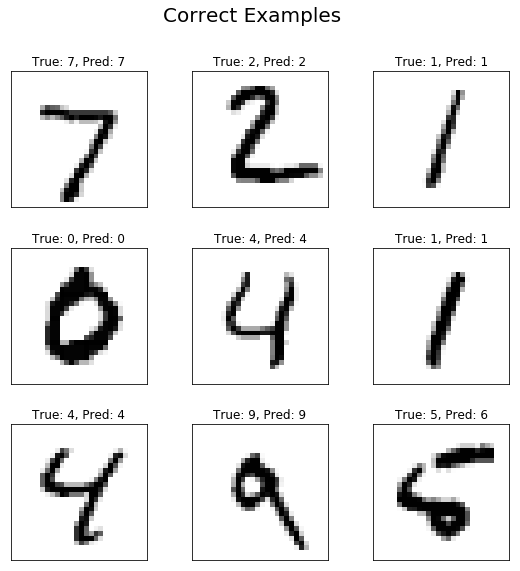

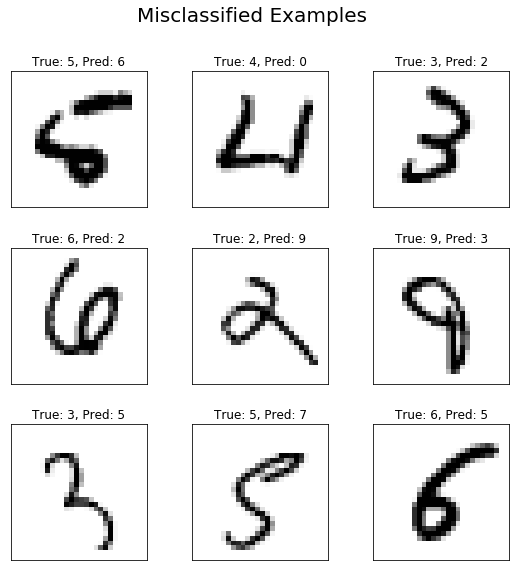

In [25]:
# Test the network after training
# Accuracy
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test[:1000], y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test[:1000], axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true, cls_pred, title='Misclassified Examples')
plt.show()

Amazing! 92% on test data.

Thanks for reading this turorial. I hope this post has helped you to learn how to build a linear classifier from scratch in TensorFlow. In the next tutorial, we'll add TensorBoard operataions to this code to be able to visualize the network graph and its training performance in TensorBoard!

If you have any questions, feel free to leave a comment in our webpage. You can also send us feedback through the [contact us](http://www.easy-tensorflow.com/contacts) page.